In [1]:
import numpy as np
from zernipy.zernike import *
from zernipy.basis import *
from zernipy.plotting import plot_basis

using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 8.02 GB available memory


In [2]:
def Z3_1(x, dx=0):
    if dx == 0:
        return 3 * x**3 - 2 * x
    if dx == 1:
        return 9 * x**2 - 2
    if dx == 2:
        return 18 * x
    if dx == 3:
        return np.full_like(x, 18)
    if dx >= 4:
        return np.zeros_like(x)

def Z4_2(x, dx=0):
    if dx == 0:
        return 4 * x**4 - 3 * x**2
    if dx == 1:
        return 16 * x**3 - 6 * x
    if dx == 2:
        return 48 * x**2 - 6
    if dx == 3:
        return 96 * x
    if dx == 4:
        return np.full_like(x, 96)
    if dx >= 5:
        return np.zeros_like(x)

def Z6_2(x, dx=0):
    if dx == 0:
        return 15 * x**6 - 20 * x**4 + 6 * x**2
    if dx == 1:
        return 90 * x**5 - 80 * x**3 + 12 * x
    if dx == 2:
        return 450 * x**4 - 240 * x**2 + 12
    if dx == 3:
        return 1800 * x**3 - 480 * x
    if dx == 4:
        return 5400 * x**2 - 480
    if dx == 5:
        return 10800 * x
    if dx == 6:
        return np.full_like(x, 10800)
    if dx >= 7:
        return np.zeros_like(x)

l = np.array([3, 4, 6, 4])
m = np.array([1, 2, 2, 2])
r = np.linspace(0, 1, 11)  # rho coordinates
max_dr = 0
desired = {
    dr: np.array([Z3_1(r, dr), Z4_2(r, dr), Z6_2(r, dr), Z4_2(r, dr)]).T
    for dr in range(max_dr + 1)
}
radial = {dr: zernike_radial_rory(r, l, m, dr) for dr in range(max_dr + 1)}
for dr in range(max_dr + 1):
    np.testing.assert_allclose(radial[dr], desired[dr], err_msg=dr)

# TESTS

In [10]:
basis = ZernikePolynomial(L=10, M=10, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

In [27]:
dr = 0
print(f"zernike_radial, derivative order: {dr}")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_separate(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

zernike_radial, derivative order: 0
75.3 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
48.2 µs ± 6.01 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
330 µs ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
130 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
dr = 1
print(f"zernike_radial, derivative order: {dr}")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_separate(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

zernike_radial, derivative order: 1
The slowest run took 4.15 times longer than the fastest. This could mean that an intermediate result is being cached.
174 µs ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
79.4 µs ± 554 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
406 µs ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
230 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
dr = 2
print(f"zernike_radial, derivative order: {dr}")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_separate(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

zernike_radial, derivative order: 2
2.76 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.59 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.12 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.2 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
dr = 3
print(f"zernike_radial, derivative order: {dr}")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_separate(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit -n 100 _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

zernike_radial, derivative order: 3
2.95 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.61 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.55 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.2 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


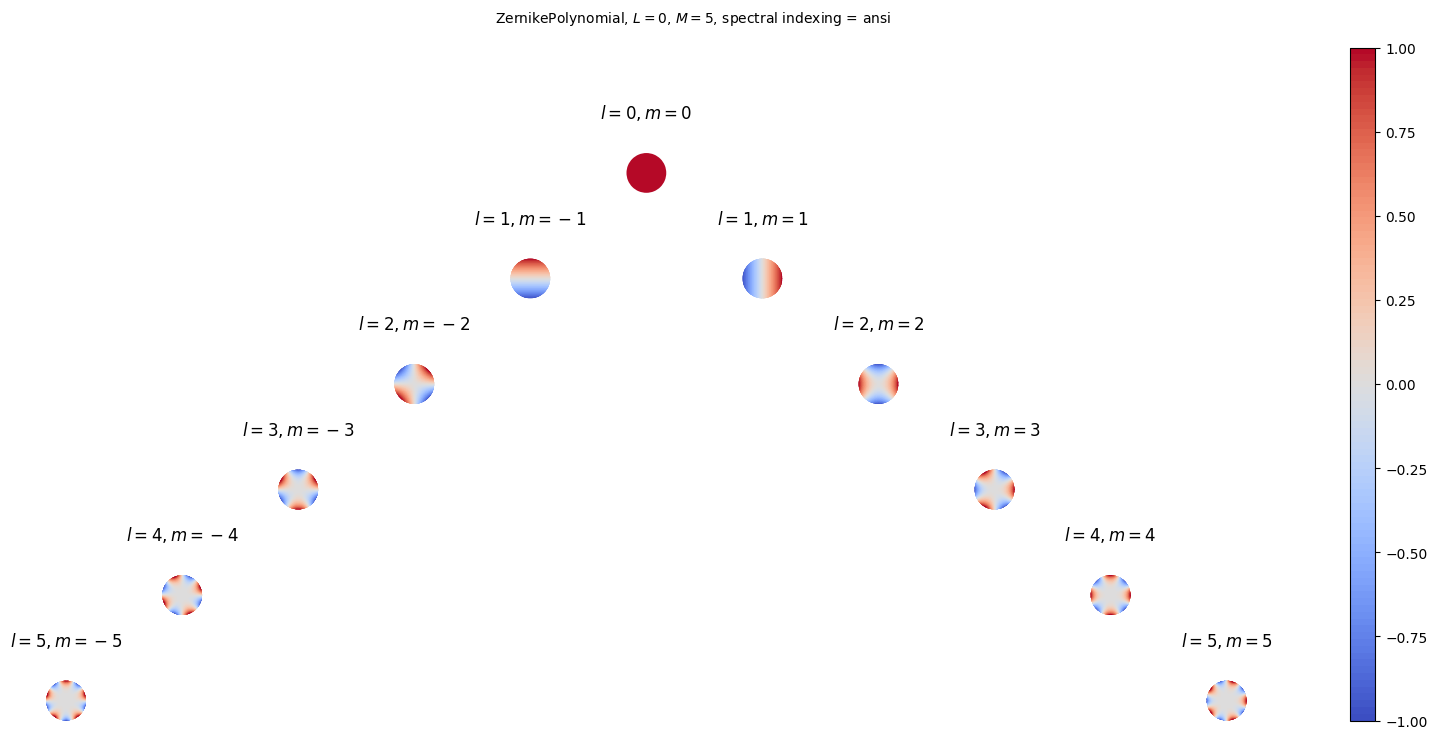

In [4]:
basis = ZernikePolynomial(L=0, M=5, spectral_indexing="ansi")
plot_basis(basis);